# Convolutional Neural Network (CNN) for Intel Image Classification Dataset
### Data

This code was inspired from this [kaggle code](https://www.kaggle.com/code/vyom71/image-classification-cnn-intel-data).

The dataset consists of approximately 25,000 images, each resized to 150x150 pixels, categorized into six classes:

| Class     | Label |
|-----------|-------|
| Buildings | 0     |
| Forest    | 1     |
| Glacier   | 2     |
| Mountain  | 3     |
| Sea       | 4     |
| Street    | 5     |

The dataset is structured into three parts:

- **Train**: ~14,000 images for training models.
- **Test**: ~3,000 images for testing.
- **Prediction**: ~7,000 images for model evaluation.


## Loading the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import kagglehub
import os

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/Users/nelsonloureiro/anaconda3/envs/MCD/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /Users/nelsonloureiro/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


In [3]:
train_dir = f"{path}/seg_train/seg_train"
test_dir = f"{path}/seg_test/seg_test"

In [4]:
classes = os.listdir(train_dir)
print("Classes: ",classes)

Classes:  ['forest', 'buildings', 'glacier', 'street', 'mountain', 'sea']


In [5]:
for cls in classes:
    print(f"{cls}: {len(os.listdir(os.path.join(train_dir, cls)))} images")  
total = sum(len(os.listdir(os.path.join(train_dir, cls))) for cls in classes)
print(f"Total images are {total}")

forest: 2271 images
buildings: 2191 images
glacier: 2404 images
street: 2382 images
mountain: 2512 images
sea: 2274 images
Total images are 14034


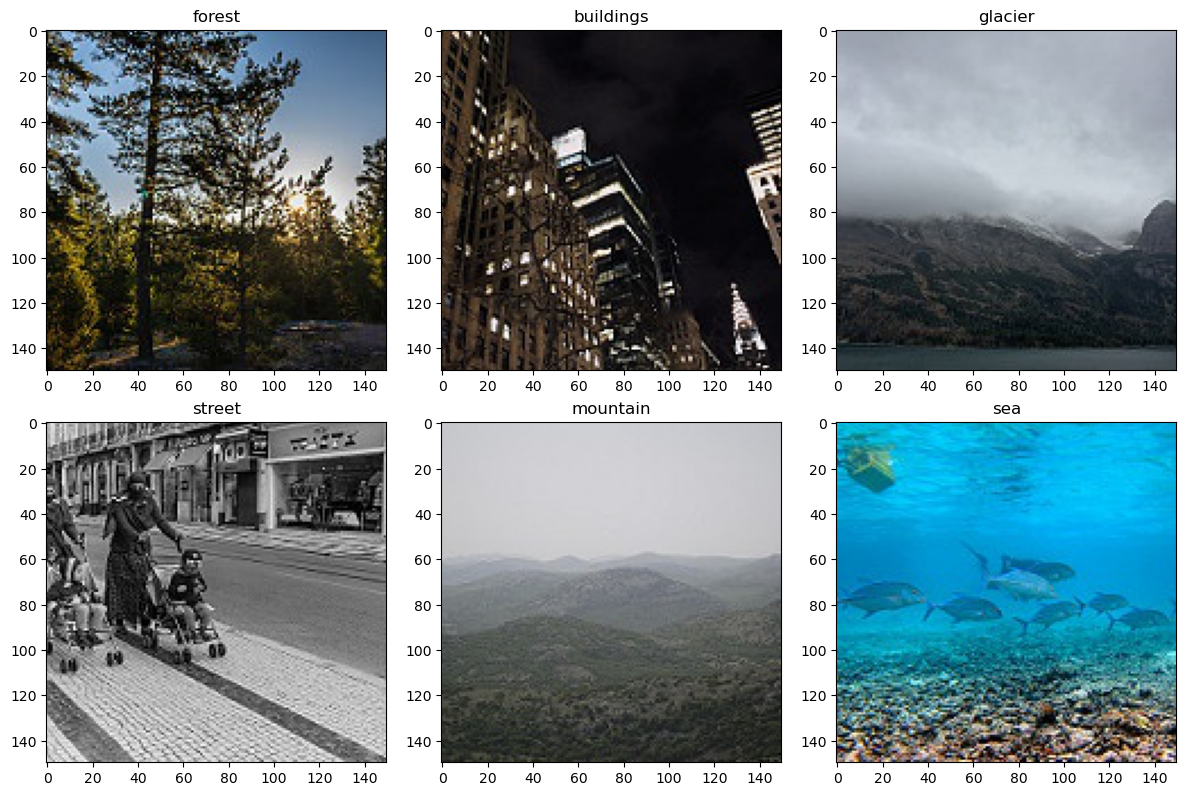

In [6]:
plt.figure(figsize=(12,8))
for i,cls in enumerate(classes):
    cls_path = os.path.join(train_dir,cls)
    img_path = os.path.join(cls_path,os.listdir(cls_path)[0])
    img = Image.open(img_path)
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(cls)

plt.tight_layout()
plt.show()

In [7]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode = 'nearest',
    validation_split = 0.2
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

#### I created 3 pipelines for Training, Validation and Testing data so Flow From Directory take cares about everything from data gethering from directory apply data augmentation (on-the-fly) divide into training and validation classes with given batch_size and target_size

In [8]:
img_size = (150,150)
batch_size = 32

print('Training subset:')
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    shuffle = True,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training'
)

print('\nValidation subset:')
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    shuffle = True,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation'
)

print('\nTest subset:')
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = img_size,
    shuffle = True,
    batch_size = batch_size,
    class_mode = 'categorical'
)

Training subset:
Found 11230 images belonging to 6 classes.

Validation subset:
Found 2804 images belonging to 6 classes.

Test subset:
Found 3000 images belonging to 6 classes.


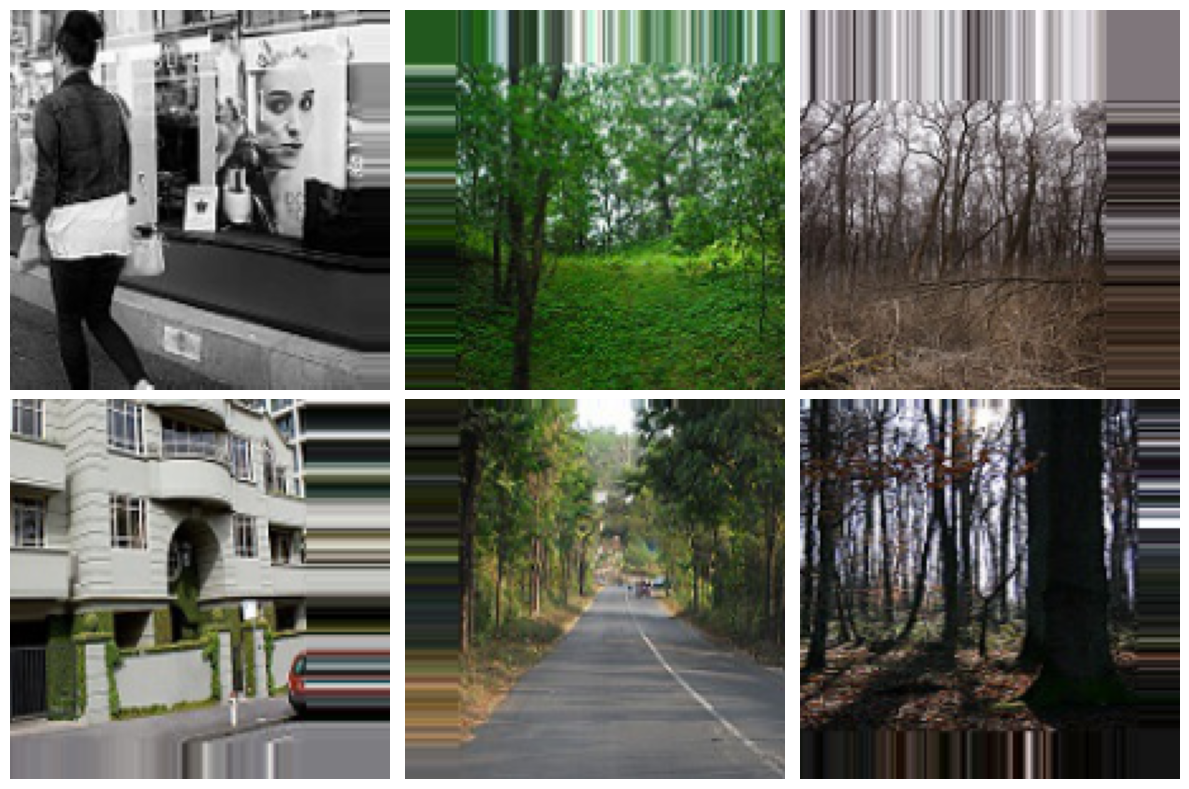

In [9]:
# Displaying a single batch of images
x_batch , y_batch = next(train_generator)

plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(x_batch[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
x_batch.shape, y_batch.shape

((32, 150, 150, 3), (32, 6))

## CNN Model

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,BatchNormalization,Dropout,Activation,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
import numpy as np

%load_ext tensorboard
from tensorboard.plugins.hparams import api as hp

## Defining hyperparameters

In [12]:
BATCH_SIZE = 32
HP_KERNEL_SIZE = hp.HParam('kernel_size', hp.Discrete([3, 5, 7]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.2, 0.5]))
#HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_KERNEL_SIZE, HP_DROPOUT],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

## Creating functions for training our model and for logging purposes

In [13]:
def train_test_model(hparams):
  model = tf.keras.models.Sequential([
    Input(shape=(150,150,3)),
    Conv2D(filters=32, kernel_size=hparams[HP_KERNEL_SIZE], activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    #BatchNormalization(),

    Conv2D(filters=64,kernel_size=hparams[HP_KERNEL_SIZE], activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    #BatchNormalization(),

    Conv2D(filters=128,kernel_size=hparams[HP_KERNEL_SIZE], activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    #BatchNormalization(),

    Flatten(), 
    Dense(512, activation='relu'),
    Dropout(hparams[HP_DROPOUT]),
    Dense(6, activation='softmax')
  ])

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  
  model.fit(
    train_generator,
    # In one epoch the generator will pass through all the training samples once. 
    steps_per_epoch = int( np.ceil(train_generator.samples / batch_size) ),
    epochs=30,
    validation_data=validation_generator,
    validation_steps = int( np.ceil(validation_generator.samples / batch_size) )
  )
  
  _, test_accuracy = model.evaluate(
    test_generator,  
    steps=test_generator.samples // batch_size  
  )

  return test_accuracy

In [14]:
# Creating a function to log the resuls
def run(log_dir, hparams):
    with tf.summary.create_file_writer(log_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

## Training the model with the different hyperparameters

In [15]:
# Performing a grid search on the hyperparameters we need to test
session_num = 0

for kernel_size in HP_KERNEL_SIZE.domain.values:
    for dropout in HP_DROPOUT.domain.values:
        hparams = {
            HP_KERNEL_SIZE: kernel_size,
            HP_DROPOUT: dropout
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('logs/hparam_tuning/' + run_name, hparams)

        session_num += 1

--- Starting trial: run-0
{'kernel_size': 3, 'dropout': 0.2}


/Users/nelsonloureiro/anaconda3/envs/MCD/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 245s 694ms/step - accuracy: 0.4670 - loss: 1.3863 - val_accuracy: 0.6566 - val_loss: 0.8964
Epoch 2/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 226s 644ms/step - accuracy: 0.6778 - loss: 0.8518 - val_accuracy: 0.7290 - val_loss: 0.7410
Epoch 3/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 226s 644ms/step - accuracy: 0.7308 - loss: 0.7177 - val_accuracy: 0.7575 - val_loss: 0.6901
Epoch 4/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 229s 652ms/step - accuracy: 0.7545 - loss: 0.6639 - val_accuracy: 0.7675 - val_loss: 0.6339
Epoch 5/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 224s 638ms/step - accuracy: 0.7831 - loss: 0.5902 - val_accuracy: 0.7981 - val_loss: 0.5811
Epoch 6/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 224s 636ms/step - accuracy: 0.7992 - loss: 0.5491 - val_accuracy: 0.8021 - val_loss: 0.5479
Epoch 7/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 229s 652ms/step - accuracy: 0.8015 - loss: 0.5401 - val_accuracy: 0.7889 - val_loss: 0.5863
Epoch 8/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 229s 653ms/step - accuracy: 0.8165 -

## Visualizing the hyperparameter results with Tensorboard

In [20]:
# Loading the Tensorboard extension
%load_ext tensorboard
%tensorboard --logdir "logs/hparam_tuning"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 65042), started 0:00:33 ago. (Use '!kill 65042' to kill it.)